# url: https://esu-ko.hatenablog.com/entry/2020/07/20/Python%E3%81%A7%E3%83%87%E3%83%BC%E3%82%BF%E3%82%B5%E3%82%A4%E3%82%A8%E3%83%B3%E3%82%B9%28%E7%94%9F%E5%AD%98%E6%99%82%E9%96%93%E8%A7%A3%E6%9E%90%29

ビジネスの現場では、縦軸に発生日、横軸に経過日の表での残存をみる俗にいうコホート分析が使われることがよくあります。

これはビジネスのデータは日々更新され、始点が異なることが多いのと、終点がはっきりしないことが多いためです。

ロジスティック回帰などを用いる場合、終点がはっきりしないデータは扱いにくくなり、個人的には生存時間解析の方が使いやすいと思うことが多くなります。



# 使い方

シンプルにイベントの発生期間までをモデリングしたい場合、カプランマイアーを使います。このとき、データの作り方をよく考える必要があります。(後述)

In [1]:
!pip install lifelines

# データをつくる

今回は、二つのアプリケーションにログインするユーザが、解約するというシナリオを考えます。

この場合、観察できる期間=ログインし続けているか、と解約する(=イベント)か、というのは別の概念になっています。

これが逆にログインしなくなる場合は、イベント発生はログインが見えなくなった時ですし、そもそもログイン観察ができない場合は、前の行動からの期間を期間と設定する必要がでてきます。
ここのデータの作り方がモデリングに与える影響が強いのが生存時間解析の癖があるところです。

In [2]:
import numpy as np
import pandas as pd
import random

random.seed(42)

#経過期間はワイブル分布するとする
a = 1.5
s = np.random.weibull(a, 1000000)

#ユーザークラス
class User:
  def __init__(self):
    self.lifetime = random.choice(s)
    self.application_type = random.choice(['a','b'])
    #アプリケーションによって解約発生率を変える
    self.churn = random.choice([0,0,0,1,1]) if self.application_type == 'a' else random.choice([0,0,1,1,1])

#データフレームにする
buf = []
for i in range(30):
  u = User()
  buf.append([i, u.lifetime, u.application_type, u.churn])

df = pd.DataFrame(buf,columns = ['id','lifetime','application_type','churn'])

# このコードでは、Userクラスを使用して30人のユーザーに関するデータを生成しています。
# 各ユーザーの情報（id、lifetime、application_type、churn）が含まれるデータフレーム df が作成されます。
# idはユーザーの識別子、lifetimeは寿命、application_typeはアプリケーションタイプ、churnは解約発生率を示しています。

# フィッティングしてみる

<Axes: xlabel='timeline'>

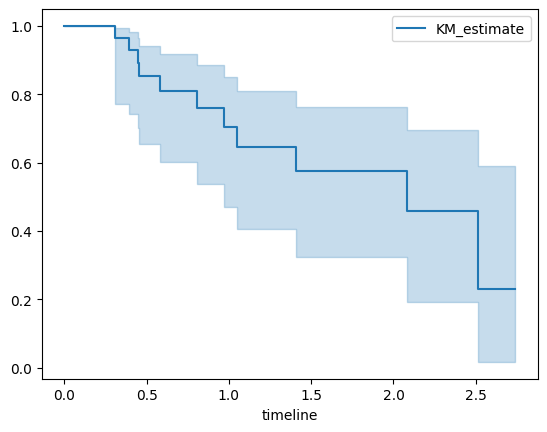

In [3]:
from lifelines import KaplanMeierFitter as kmf

mdl = kmf()
# mdl.fit(経過期間, イベント発生有無)
mdl.fit(df['lifetime'], df['churn'])

#残存を可視化してくれる。
mdl.plot()

# 横軸は経過期間、縦はそれに応じた、イベントが発生しなかった残存率です。
# 今回は経過期間こそワイブル分布にしましたが、チャーンの発生は経過期間と連動していないため、なかなか下げ止まらなくなっています。

<ipython-input-4-c071179e39e5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2['is_a'] = df['application_type'].apply(lambda x: 1 if x == 'a' else 0)


<lifelines.CoxPHFitter: fitted with 30 total observations, 19 right-censored observations>
             duration col = 'lifetime'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 30
number of events observed = 11
   partial log-likelihood = -28.37
         time fit was run = 2023-11-28 04:55:25 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
is_a        0.00       1.00       0.61            -1.19             1.19                 0.30                 3.30

            cmp to    z    p   -log2(p)
covariate                              
is_a          0.00 0.00 1.00       0.00
---
Concordance = 0.48
Partial AIC = 58.75
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.00

<Axes: xlabel='log(HR) (95% CI)'>

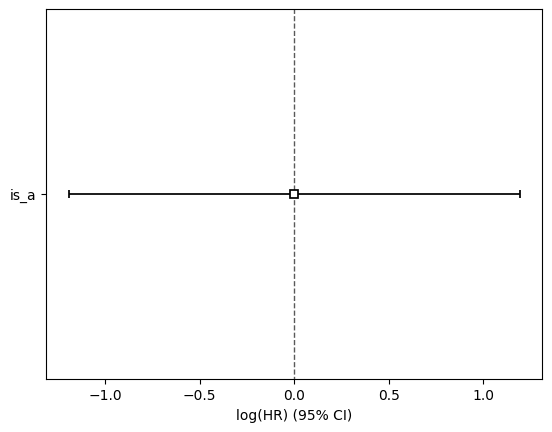

In [4]:
# coxphもやってapplication_typeの影響をみてみます。
# coxphは数値のみで、かつワンホットエンコーディングするとエラーを返すので、1つに減らした状態でやります。

# coxphは数値のみ
# 回帰のように各変数の影響をみたい場合は、CoxPHを用います。

d2 = df[['lifetime','churn']]
d2['is_a'] = df['application_type'].apply(lambda x: 1 if x == 'a' else 0)

# 以下のように処理するとワンホットエンコーディングするとエラーを返す
# # ダミー変数のデータフレーム
# dummy_df = pd.get_dummies(df['application_type'])

# # 結合
# d2 = pd.concat([d2, dummy_df], axis=1)

from lifelines import CoxPHFitter as cph

cph_mdl = cph()
# cph_mdl.fit(データ,経過期間カラム名,イベントカラム名)
cph_mdl.fit(d2, 'lifetime', 'churn')

#一般的な回帰のようなsummary
cph_mdl.print_summary()

#変量の影響度の可視化
cph_mdl.plot()

# 結果はprint_summaryでみることができます。
# 全体数では30ですが、イベント発生は19ユーザーのみ、といった基本情報と、回帰係数の情報をみることができます。

# 変量間の違いの可視化

今回は説明変数が一つしかないため、あまり意味がありませんが、一応見ておきます。

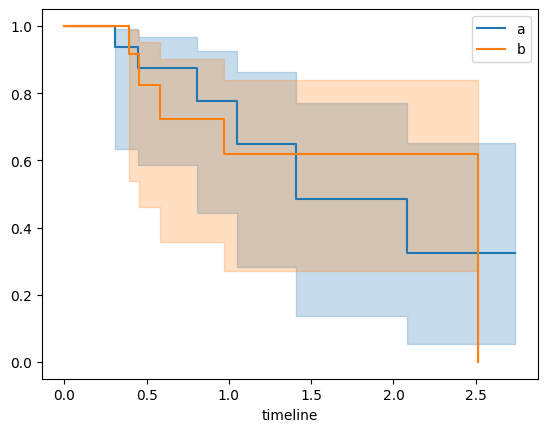

In [5]:
for app in df['application_type'].unique():
    mdl = kmf(label=app)
    tmp = df[df['application_type'] == app]
    mdl.fit(tmp['lifetime'], tmp['churn'])
    mdl.plot()

# 属性間の残存を見比べたいならkmfでplotの出し分けをします。aの方がよく残存しているように見えます。